<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Testing-of-Code" data-toc-modified-id="Testing-of-Code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Testing of Code</a></span></li><li><span><a href="#Fit-the-Particle-Filter" data-toc-modified-id="Fit-the-Particle-Filter-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fit the Particle Filter</a></span><ul class="toc-item"><li><span><a href="#Parallelize-All-Participants" data-toc-modified-id="Parallelize-All-Participants-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Parallelize All Participants</a></span></li><li><span><a href="#Test-Individual-Participants" data-toc-modified-id="Test-Individual-Participants-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Test Individual Participants</a></span></li></ul></li></ul></div>

# Testing of Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import distributions as dist
from collections import Counter
from scipy.optimize import minimize, Bounds
import math
import pickle

In [2]:
from functools import partial, reduce
from multiprocessing import Pool

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from models import particle as ptcl

In [5]:
run = 0
stims, labels = ptcl.get_zmstims(400)
types = "cc"
Cparam = 0.65
mu0 = np.mean(stims, 0)
sigma0 = np.var(stims, 0)
lambda0 = np.ones(len(stims[0]))
a0 = np.ones(len(stims[0]))
n_labels = 4
feedback = [1, 2, 3, 1, 2, 2, 2, 4, 3, 1]

args = [Cparam, mu0, sigma0, lambda0, a0, types, n_labels, feedback]

model = ptcl.RationalParticle(args, decision = "MAP")

In [6]:
model.N = 1
model.partition = [0]

In [7]:
model.labelprob()

array([0.25, 0.25, 0.25, 0.25])

In [8]:
model.N = 2
model.partition = [0, 0]

In [9]:
model.labelprob()

array([[0.4 , 0.2 , 0.2 , 0.2 ],
       [0.25, 0.25, 0.25, 0.25]])

# Fit the Particle Filter

Model Selection Logic:
1. run training trials with the model; feedback is provided, therefore, the label counts are updated according to the true category label during training
2. replicate 1. with several values for c and return all models
3. make predictions on hold out transfer data for all combinations
4. select best fitting c parameter for every participant

nb. fit only c parameter, keep others fixed

In [7]:
tbl_train = pd.read_csv("data/tbl_train.csv")
tbl_transfer = pd.read_csv("data/tbl_transfer.csv")

In [8]:
tbl_train["trial_id"] = tbl_train.groupby("participant").cumcount()+1

In [9]:
tbl_train.value_counts("participant").head()

participant
147    992
108    992
129    992
113    992
124    992
dtype: int64

In [10]:
tbl_train_small = tbl_train[tbl_train["trial_id"] < 100].copy()

In [11]:
tbl_train_small[tbl_train_small["participant"] == 104]["category_int"].unique()

array([3, 1, 2], dtype=int64)

## Parallelize All Participants

takes approx. 80 mins to fit one batch of participants (1 batch = 4 participants in parallel)

batchsize can be increased to max 16 on the lab computer. so maybe 14 participants in parallel take 80 mins

50 participants / 14 takes approx. 4 * 80 mins = 320 mins = 6h 20mins

In [15]:
l_results_train = ptcl.multiprocessing_grid_search_particle(tbl_train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [5:31:28<00:00, 397.77s/it]


In [17]:
r_o_w = "write"

In [12]:
if r_o_w == "write":
    with open("data/lists-trained-models.pickle", "wb") as f:
        pickle.dump(l_results_train, f)
elif r_o_w == "read":
    with open("data/lists-trained-models.pickle", "rb") as f:
        l_results_train = pickle.load(f)

In [13]:
for l in l_results_train:
    l["tbl_transfer"] = tbl_transfer[tbl_transfer["participant"] == l["id"]]

37 seconds with 20 data points

143 seconds with 40 data points on personal laptop (but trained on 40 training data points as well)

on lab computer 420 seconds with 40 data points to predict, but full data set trained

In [14]:
l_results_transfer = ptcl.multiprocessing_prediction(l_results_train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [4:32:22<00:00, 326.85s/it]


In [18]:
if r_o_w == "write":
    with open("data/lists-transfer-models.pickle", "wb") as f:
        pickle.dump(l_results_transfer, f)
elif r_o_w == "read":
    with open("data/lists-transfer-models.pickle", "rb") as f:
        l_results_transfer = pickle.load(f)

In [19]:
df_results_transfer = reduce(lambda x, y: pd.concat([x, y]), l_results_transfer)

In [20]:
df_results_transfer["rank"] = df_results_transfer.groupby("id")["ll"].rank(ascending=False)

In [39]:
df_top_rank = df_results_transfer.query("rank == 1").copy()

In [42]:
df_top_rank["ll_rank"] = df_top_rank["ll"].rank(ascending=False)

<AxesSubplot: xlabel='c', ylabel='ll_rank'>

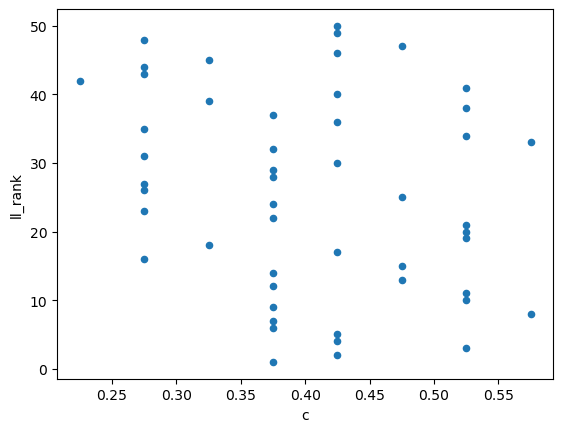

In [50]:
df_top_rank.sort_values("ll_rank").plot.scatter("c", "ll_rank")

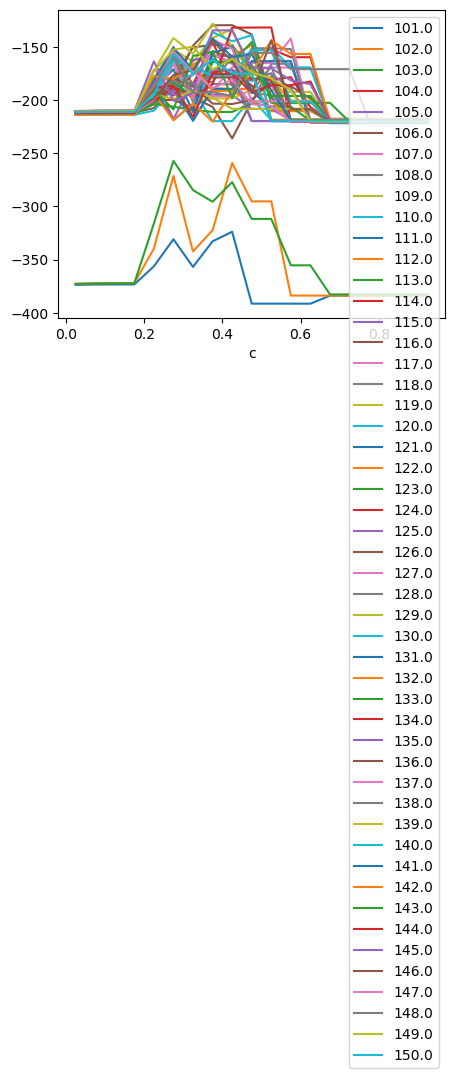

In [22]:
fig, ax = plt.subplots(figsize=(5, 4))
for label, df in df_results_transfer.groupby("id"):
    df.plot("c", "ll", ax=ax, label=label)
_ = plt.legend()

did not store final number of clusters after transfer

therefore, take number of clusters after train

In [88]:
nk = list()
best_c = list()
for idx, l in enumerate(l_results_transfer):
    c_best_idx = l["ll"].argmax()
    nk.append(l_results_train[idx]["model"][c_best_idx].clusters)
    best_c.append(l_results_train[idx]["cs"][c_best_idx])

In [91]:
df_results_transfer

,id,c,ll,rank
0,101.0,0.025,-373.716269,9.0
0,101.0,0.075,-373.402469,8.0
0,101.0,0.125,-373.337468,7.0
0,101.0,0.175,-373.309373,6.0
0,101.0,0.225,-356.344290,4.0
...,...,...,...,...
0,150.0,0.725,-219.258230,14.0
0,150.0,0.775,-219.258265,15.0
0,150.0,0.825,-219.258297,16.0
0,150.0,0.875,-219.258324,17.0


In [98]:
n_reps = df_results_transfer.groupby("id").count().loc[101.0, "c"]

In [99]:
df_results_transfer["c_best"] = np.repeat(best_c, n_reps)
df_results_transfer["nk"] = np.repeat(nk, n_reps)

In [101]:
df_results_transfer.to_csv("data/tbl-results-transfer.csv")

In [79]:
df_results_transfer

,id,c,ll,rank
0,101.0,0.025,-373.716269,9.0
0,101.0,0.075,-373.402469,8.0
0,101.0,0.125,-373.337468,7.0
0,101.0,0.175,-373.309373,6.0
0,101.0,0.225,-356.344290,4.0
...,...,...,...,...
0,150.0,0.725,-219.258230,14.0
0,150.0,0.775,-219.258265,15.0
0,150.0,0.825,-219.258297,16.0
0,150.0,0.875,-219.258324,17.0


In [ ]:
l_results_train[0]["cs"][c_best_idx]

## Test Individual Participants

In [ ]:
stim_train_101 = tbl_train_small[tbl_train_small["participant"] == 101][["d1i", "d2i"]].to_numpy()
fb_train_101 = tbl_train_small[tbl_train_small["participant"] == 101]["category_int"].to_numpy()

In [ ]:
ll, n_clusters, model = ptcl.fit_ll(
    np.array([.1]), stim_train_101, fb_train_101
)

In [ ]:
stim_pred = tbl_transfer[tbl_transfer["participant"] == 101][["d1i", "d2i"]].to_numpy()[0:20,]

In [ ]:
fb_pred = tbl_transfer[tbl_transfer["participant"] == 101]["category_int"].to_numpy()[0:20,]

In [ ]:
d_pred = {"model": model, "stimuli": stim_pred, "feedback": fb_pred}

In [ ]:
ll, K, model = ptcl.predict_ll(d_pred)

In [ ]:
ll, K, model = ptcl.predict_ll(model, np.array([[-1000, -1000]]), np.array([[1]]))

In [ ]:
stimnum = l_results[3]["model"][10].register_item(stim, checkduplicate=False)
# compute posterior over observed features
l_results[3]["model"][10].computeposterior(stimnum)

In [ ]:
stimnum = l_results[5]["model"][10].register_item(stim, checkduplicate=False)
# compute posterior over observed features
l_results[5]["model"][10].computeposterior(stimnum)

In [ ]:
stimnum

In [ ]:
l_results[0]["model"].currentposterior

In [ ]:
l_results[0]["model"].stims

In [ ]:
l_results[0]["model"].additem_particle([3, 2])

In [ ]:
math.log(l_results[0]["model"].plf[-1].flatten("C")[2])

In [ ]:
p1 = tbl_train[tbl_train["participant"] == 101]

In [ ]:
p1 = p1.iloc[0:100,:].copy()


In [ ]:
ptcl.grid_search_particle(p1)

In [ ]:
l_results = list(map(ptcl.grid_search_particle, list_to_process_no_names))

In [ ]:
l_results

In [ ]:
l_results = ptcl.multiprocessing_grid_search_particle(tbl_train)

optimize particle filter
- takes too long, though

start_params = np.array([.5])

bounds = Bounds([0], [1])

def wrap_fit_particle(id, tbl_data):
    stimuli_subset = tbl_data[tbl_data["participant"] == id][["d1i", "d2i"]].to_numpy()
    feedback_subset = tbl_data[tbl_data["participant"] == id]["category"].to_numpy()
    c_seq = np.seq(0.025, 0.975, by=.05)
    lls = list()
    for c in c_seq:
        lls.append(fit_ll(c, stimuli_subset, feedback_subset))
    return lls

def wrap_optim(id, tbl_data):
    stimuli_subset = tbl_data[tbl_data["participant"] == id][["d1i", "d2i"]]
    feedback_subset = tbl_data[tbl_data["participant"] == id]["category"]
    res = minimize(
        ptcl.fit_ll, start_params, 
        args = (stimuli_subset, feedback_subset), 
        method = "trust-constr", bounds=bounds,
        options={'gtol': 1e-6, 'disp': True}
    )
    l_out = [id, res]
    return l_out

wrap_fit_partial = partial(ptcl.grid_search_particle, tbl_data = tbl_train)

f_partial = partial(wrap_optim, stimuli=tbl_train, feedback=feedback)
p = multiprocessing.Pool(2)
list_result = []
for x in p.imap(f_partial, participants):
    list_result.append(x)

res = minimize(
    ptcl.fit_ll, start_params, 
    args = (stimuli_np, feedback_np), 
    method = "trust-constr", bounds=bounds,
    options={'gtol': 1e-6, 'disp': True}
)